# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/4a32fd7bf343239da3cd0ecc0a5f8cad263ae0415894ae7fc96542f2.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Pine Bush, New York, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'4a32fd7bf343239da3cd0ecc0a5f8cad263ae0415894ae7fc96542f2')

In [2]:
%matplotlib notebook

## 1. Graph Max and Min Rain Data from 2005 - 2014

In [3]:
# get the data from the csv file and create DataFrame object with parsed dates.
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/4a32fd7bf343239da3cd0ecc0a5f8cad263ae0415894ae7fc96542f2.csv', 
                 parse_dates=[1])

# convert 'Date' columns to pandas datetime objects
pd.to_datetime(df['Date'])
df.head()

,ID,Date,Element,Data_Value
0,USC00302366,2008-10-25,TMIN,-67
1,USC00306649,2011-09-18,TMIN,22
2,USC00305334,2013-08-11,TMIN,67
3,USW00064756,2008-06-07,TMIN,153
4,USC00305426,2007-01-16,TMAX,89


In [4]:
# select data by specific datetime attributes
df_2015 = df.where(df['Date'].dt.year==2015).dropna()  # get all 2015 data

df = (df.where(
    df['Date'].dt.year.isin(range(2005, 2015)))        # get years 2005-2014
    .dropna()
    .set_index('Date')                                 # set index to the 'Date' col
    .sort_index())                                     # sort by date

# exclude leap days, using the tilde for inverse query (ignore df_2015, not a leap year)
df = df[~((df.index.month==2) & (df.index.day==29))]

In [5]:
df_2015.head()

,ID,Date,Element,Data_Value
5,USC00305426,2015-09-20,TMAX,250.0
16,USW00014757,2015-04-09,TMIN,22.0
20,USW00064756,2015-08-16,TMIN,165.0
27,USC00307274,2015-07-17,TMAX,261.0
45,USC00306649,2015-05-11,TMIN,144.0


In [6]:
df_2015.drop(['Element', 'ID'], axis=1, inplace=True)

In [7]:
# format days so that they are datetime-compatible (2015 used as year-placeholder and easy comparison with 2015 df)
df['Day'] = df.index.map(lambda x: '2015-{:02}-{:02}'.format(x.month, x.day))

# Group by day and month for each day of the year
records = df.groupby('Day')['Data_Value'].agg({'Record High': np.max, 'Record Low': np.min})
records.sort_index()

# convert index to datetime
records.index = records.index.to_datetime()
records.index

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', length=365, freq=None)

In [8]:
# find the 10-year record breaks for 2015

def record_break(tdf):
    breaking_highs = list()
    breaking_lows = list()
    
    # iterate over rows as tuples
    for _, date, temp in tdf.itertuples():               # unpack the date and temp from each row 
        # grab record data for this date
        ten_yr_low = records.loc[date]['Record Low']     # get ten year low from records dataframe
        ten_yr_high = records.loc[date]['Record High']   # get ten year high 
    
        # check if we broke the high or low temp record that day
        high = temp > ten_yr_high
        low = temp < ten_yr_low

        if high:
            breaking_highs.append((date, temp/10))       # add to list and convert from tenths to degrees
        elif low:
            breaking_lows.append((date, temp/10))        # same as highs

    return breaking_highs, breaking_lows

breaking_highs, breaking_lows = record_break(df_2015)

<IPython.core.display.Javascript object>


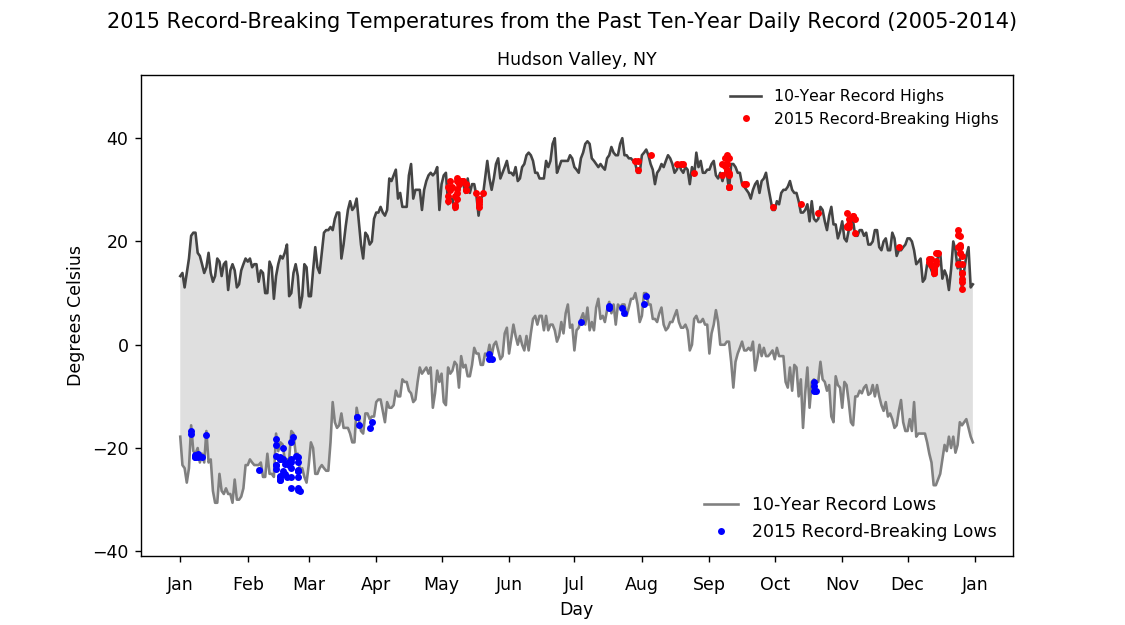

(735580.80000000005,
 735981.19999999995,
 -40.956000000000003,
 52.235999999999997)

In [23]:
import matplotlib.dates as mpl_dates
import datetime

# start new figure
ax = plt.figure(figsize=(9, 5)).add_subplot(111)

# save xdates for x-axis values
xdates = records.index

# plot both series of record high and low temps by date, with color, label
high_line, = ax.plot_date(xdates, 
                         records['Record High']/10, 
                         '-', 
                         color='#444444', 
                         label='10-Year Record Highs')

low_line, = ax.plot_date(xdates, 
                        records['Record Low']/10, 
                        '-', 
                        color='#808080', 
                        label='10-Year Record Lows')

# set a pretty major x-axis label with just months
ax.xaxis.set_major_locator(mpl_dates.MonthLocator())               # set major axis locator to find the month
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('\n\n\n%b'))  # set formatter with abbreviated month name
ax.tick_params(axis='x', pad=-28)                                  # reduce the padding from the major axis

# fill the area between the record highs and lows
ax.fill_between(xdates, records['Record High']/10, records['Record Low']/10, 
                       facecolor='grey', 
                       alpha=0.25)

# unpack data for 2015 record breaks
hdates, htemps = zip(*breaking_highs)
ldates, ltemps = zip(*breaking_lows)

# plot 2015 anomalies
scatter_high, = ax.plot_date(hdates, htemps, '.', color='red', label='2015 Record-Breaking Highs')
scatter_low, = ax.plot_date(ldates, ltemps, '.', color='blue', label='2015 Record-Breaking Lows')

# create legend for Highs
legend1 = plt.legend(loc=1, 
           frameon=False, 
           fontsize=9,
           handles=[high_line, scatter_high]
           )

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(legend1)

# Create another legend for the second line.
plt.legend(handles=[low_line, scatter_low], 
           loc=4,
           frameon=False)

# add titles
plt.suptitle('2015 Record-Breaking Temperatures from the Past Ten-Year Daily Record (2005-2014)', fontsize=12)
plt.title('Hudson Valley, NY', fontsize=10)
plt.ylabel('Degrees Celsius')
plt.xlabel('Day')

x1,x2,y1,y2 = plt.axis()

plt.axis((x1, x2, y1*1.2, y2*1.2))